In [18]:
# ! rm -r ./yolov5/runs
%cd ./yolov5/

/notebooks/yolov5


In [3]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
!git reset --hard fbe67e465375231474a2ad80a4389efc77ecff99

Cloning into 'yolov5'...
remote: Enumerating objects: 14974, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 14974 (delta 6), reused 9 (delta 3), pack-reused 14960
Receiving objects: 100% (14974/14974), 13.65 MiB | 20.59 MiB/s, done.
Resolving deltas: 100% (10350/10350), done.
/notebooks/yolov5
Updating files: 100% (87/87), done.
HEAD is now at fbe67e4 Fix `OMP_NUM_THREADS=1` for macOS (#8624)


In [4]:
!pip install roboflow -q

from roboflow import Roboflow
rf = Roboflow(api_key="neIVZe1oNb0LYT5wm4nT")
project = rf.workspace("proapril").project("lp2-govx7")
dataset = project.version(7).download("yolov5")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to LP2-7 in yolov5pytorch:: 100%|██████████| 7064/7064 [00:07<00:00, 949.12it/s] 


In [19]:
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
from utils.downloads import attempt_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.12.0+cu116 _CudaDeviceProperties(name='NVIDIA RTX A4000', major=8, minor=6, total_memory=16117MB, multi_processor_count=48)


In [20]:
%cat LP2-7/data.yaml

names:
- '0'
- licence
nc: 2
train: LP2-7/train/images
val: LP2-7/valid/images


In [21]:
# define number of classes based on YAML
import yaml
with open("LP2-7/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [22]:
%cat models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

In [23]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [24]:
%%writetemplate models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [25]:
!python train.py --img 416 --batch 16 --epochs 500 --data ./LP2-7/data.yaml --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache

train: weights=, cfg=./models/custom_yolov5s.yaml, data=./LP2-7/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=500, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5s_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: ⚠️ YOLOv5 is out of date by 336 commits. Use `git pull` or `git clone https://github.com/ultralytics/yolov5` to update.
YOLOv5 🚀 v6.1-306-gfbe67e4 Python-3.9.13 torch-1.12.0+cu116 CUDA:0 (NVIDIA RTX A4000, 16117MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5,

In [26]:
# Start tensorboard
# Launch after you have started training
# logs save in the folder "runs"
%load_ext tensorboard
%tensorboard --logdir runs

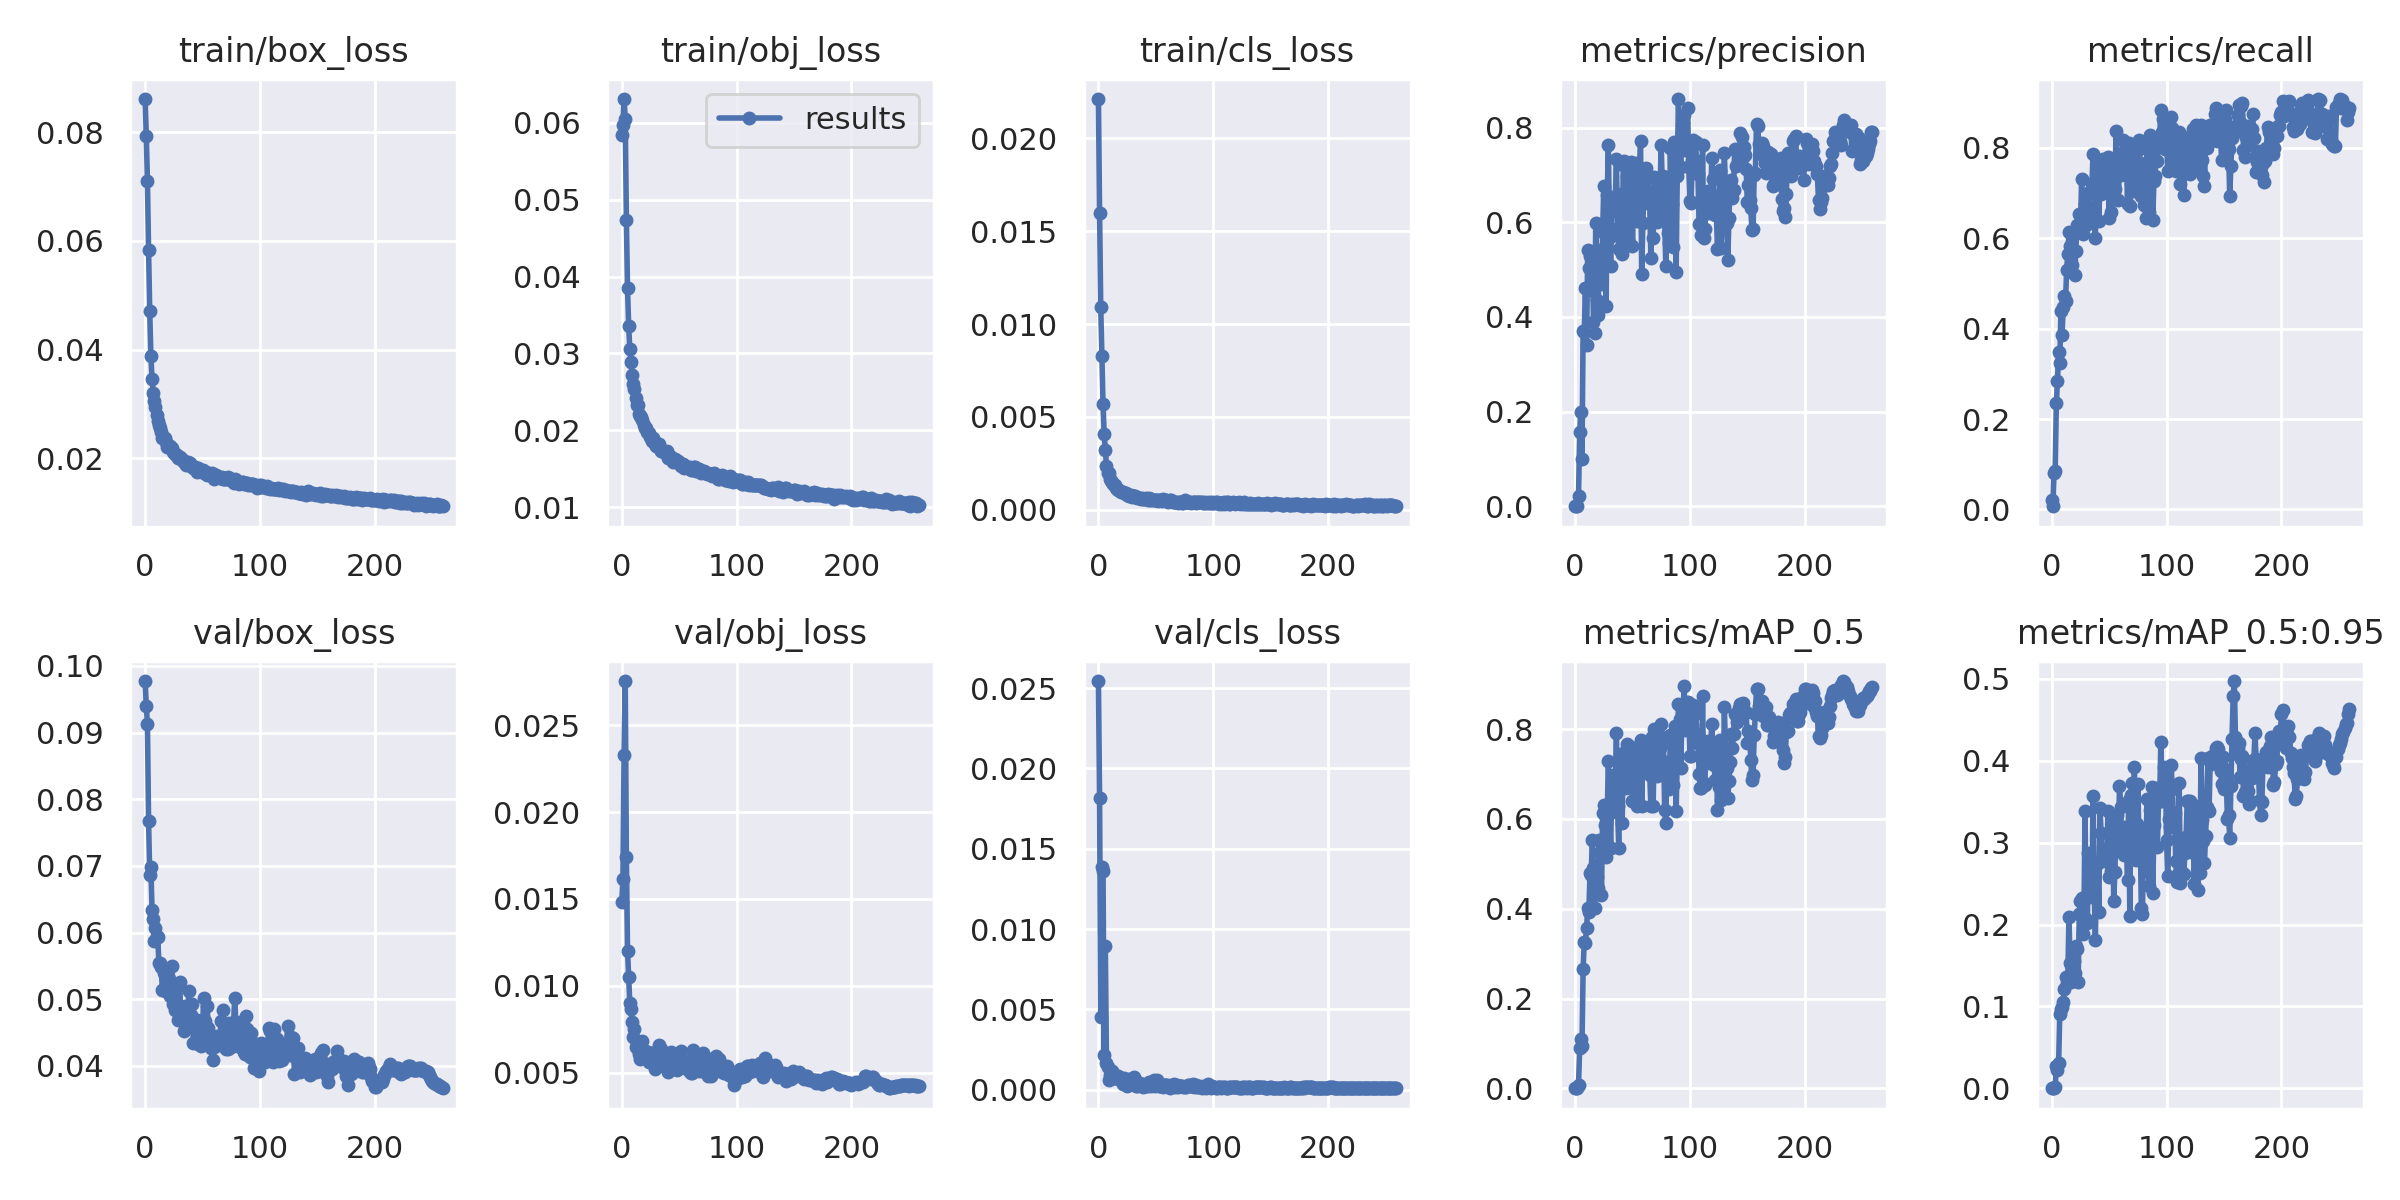

In [27]:
# we can also output some older school graphs if the tensor board isn't working for whatever reason... 
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='./runs/train/yolov5s_results/results.png', width=1000)  # view results.png

In [28]:
!python detect.py --weights runs/train/yolov5s_results/weights/best.pt --img 416 --conf 0.4 --source ./LP2-7/test/images

detect: weights=['runs/train/yolov5s_results/weights/best.pt'], source=./LP2-7/test/images, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-306-gfbe67e4 Python-3.9.13 torch-1.12.0+cu116 CUDA:0 (NVIDIA RTX A4000, 16117MiB)

Fusing layers... 
custom_YOLOv5s summary: 232 layers, 7249215 parameters, 0 gradients, 16.7 GFLOPs
image 1/25 /notebooks/yolov5/LP2-7/test/images/Cars101_png.rf.f7cb6e20c70e75e8e7033187de32a335.jpg: 416x416 1 licence, Done. (0.006s)
image 2/25 /notebooks/yolov5/LP2-7/test/images/Cars109_png.rf.2f34afab94924e9de85c2b2684a72f6e.jpg: 416x416 1 licence, Done. (0.006s)
image 3/25 /notebooks/yolov5/LP2-7/test/images/Cars114_png.rf.51

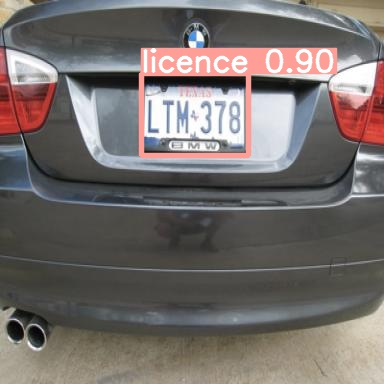

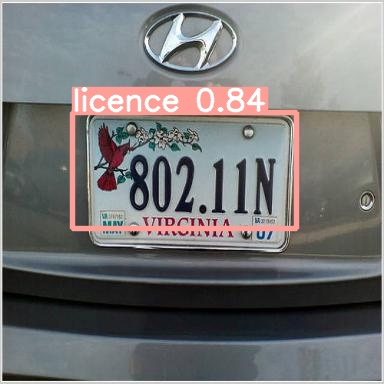

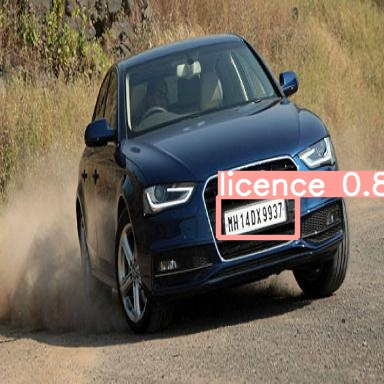

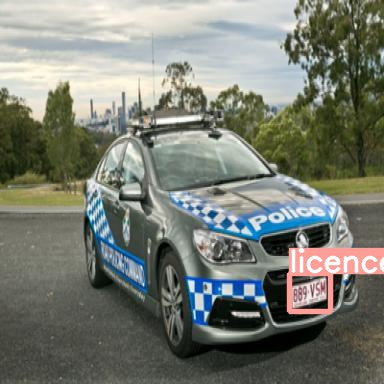

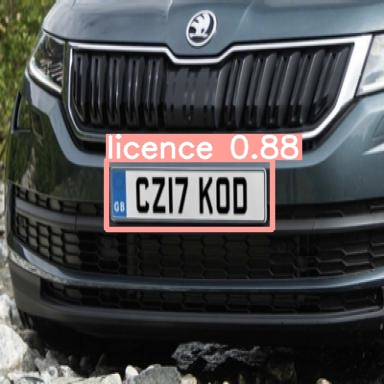

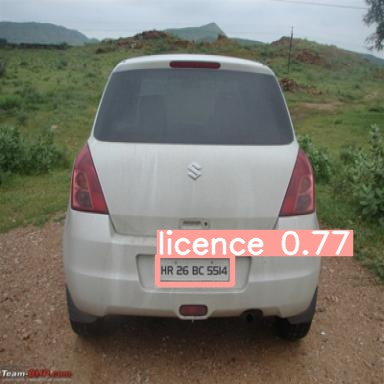

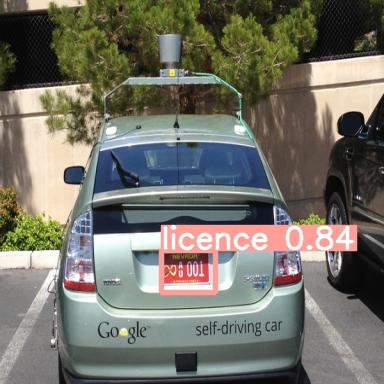

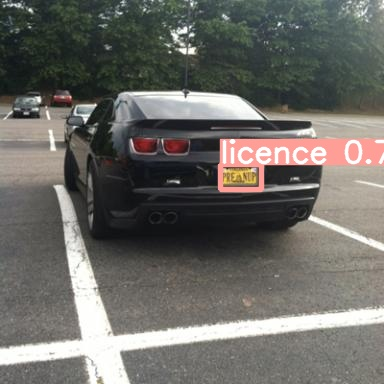

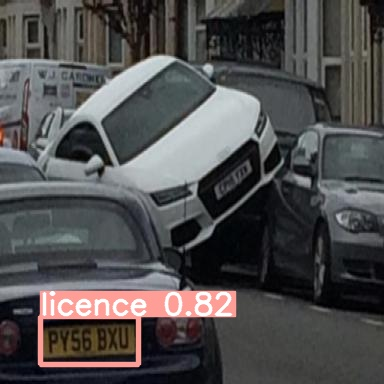

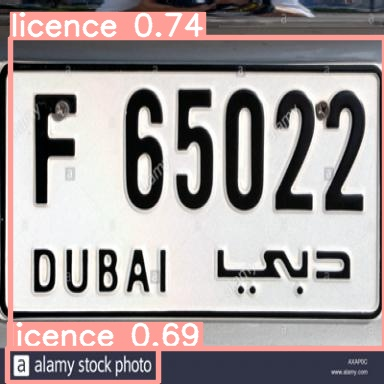

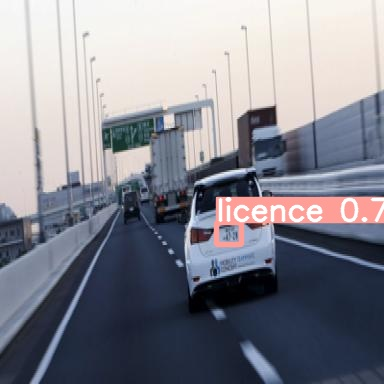

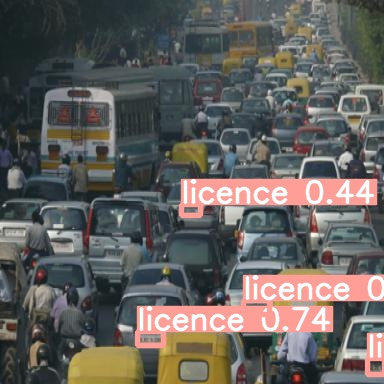

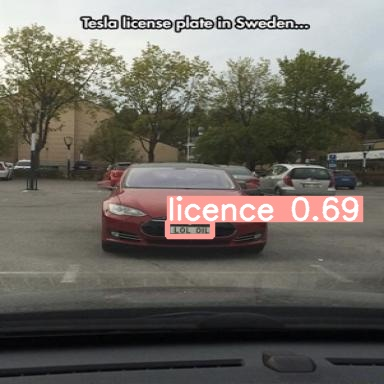

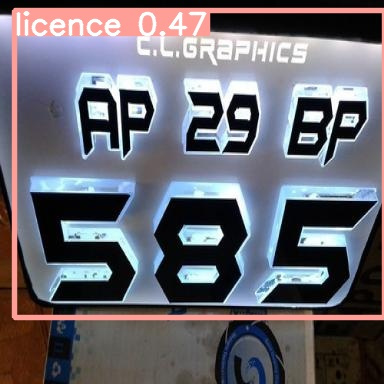

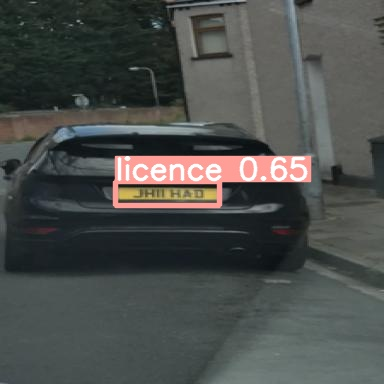

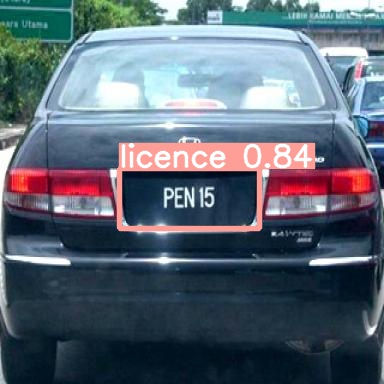

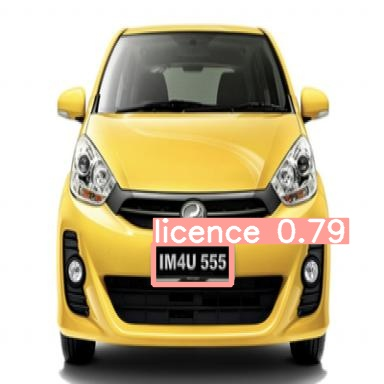

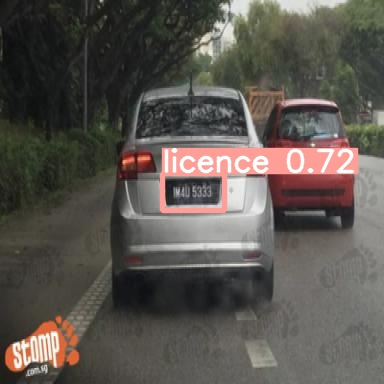

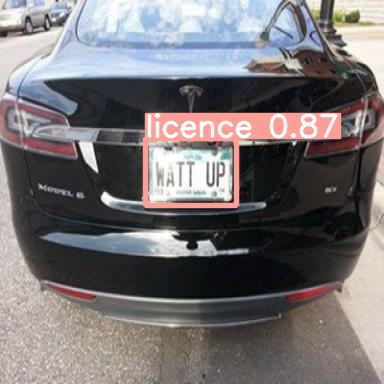

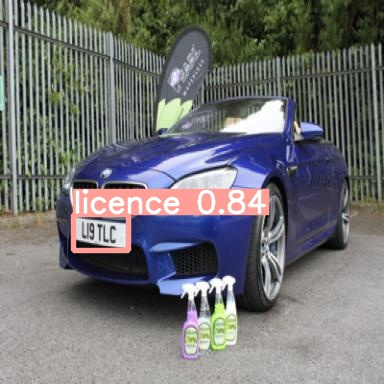

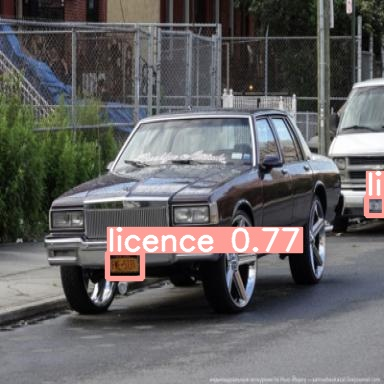

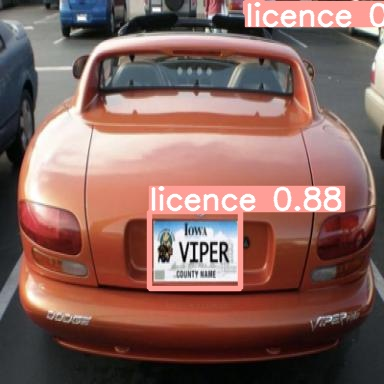

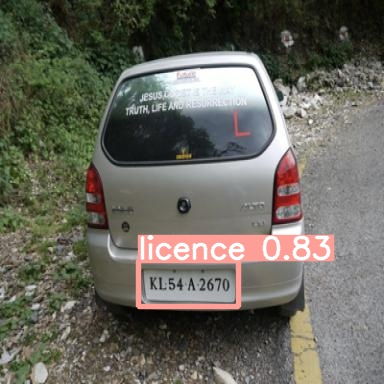

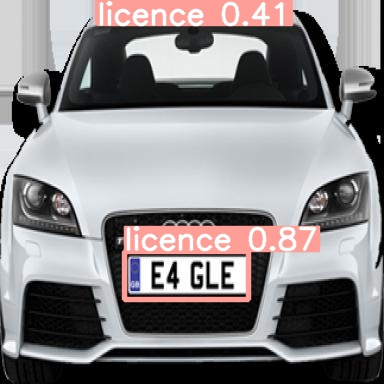

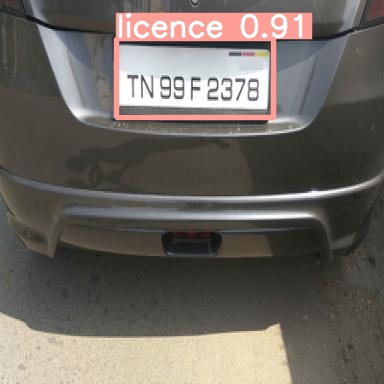

In [29]:
#display inference on ALL test images
#this looks much better with longer training above

import glob
from IPython.display import Image, display

for imageName in glob.glob('./runs/detect/exp/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

In [1]:
import torch
model = torch.hub.load('../yolov5', 'custom', path='../yolov5/runs/train/yolov5s_results/weights/best.pt', source='local')

/home/pk/miniconda3/envs/Automatic_number_plate/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
YOLOv5 🚀 v6.1-306-gfbe67e4 Python-3.8.15 torch-1.12.1+cpu CPU

Fusing layers... 
custom_YOLOv5s summary: 232 layers, 7249215 parameters, 0 gradients, 16.7 GFLOPs
Adding AutoShape... 


In [5]:
from PIL import Image
img = Image.open('../pen.jpeg')
model.conf = .5

In [6]:
prediction = model(img)

In [7]:
prediction.save("num_test.jpg")

Saved 1 image to runs/detect/exp


In [8]:
result = prediction.pandas().xyxy[0]

In [12]:
len(result)

0

In [11]:
result.iloc[0].tolist()[:4]

IndexError: single positional indexer is out-of-bounds

In [21]:
cropped_imge = img.crop((result.iloc[0].tolist()[:4]))

In [22]:
cropped_imge.save("c.jpeg")

In [23]:
!pip install easyocr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 101.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 MB 42.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 kB 51.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 119.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.0/608.0 kB 101.1 MB/s eta 0:00:00


In [24]:
import matplotlib.pyplot as plt
import cv2
import easyocr
from IPython.display import Image

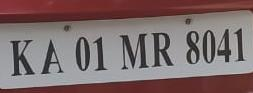

In [25]:
Image("c.jpeg")

In [26]:
reader = easyocr.Reader(['en'])

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Download complete


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Download complete.


In [28]:
output = reader.readtext('c.jpeg')

In [32]:
output[0][1]

'Ka 01 MR 8041'